# NGA Standardization Notebook
---
---

# Table of contents
1. [PRE-PROCESSING](#preprocess)
    1. [Load fcover data](#loadfcover)
    2. [Join fcover to species checklist table](#joinchecklist)
    3. [Join fcover to leaf retention table](#joinleafretention)
    4. [Export species-PFT tables](#exporthabits)
    5. [Clean exported species-PFT tables](#cleanhabits)
2. [STANDARDIZATION](#standardization)
    1. [Standardize PFT names](#pftnames)
    2. [Sum species fcover to PFT-level](#sumfcover)
    3. [Standardize table layout](#tablelayout)
    4. [Standardize auxiliary columns](#aux)
        1. [Basic plot information](#basics)
        2. [Geographical intersections](#geo)
        3. [Duplicate coordinates](#dupes)
3. [EXPORT](#export)

# Load required packages

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from pyogrio import read_dataframe
import glob
import geopandas as gpd
import sys
import os
import chardet
from urllib.request import urlretrieve
from shapely.validation import make_valid
import importlib

In [2]:
# import local functions
current_dir = os.path.abspath('..')
if current_dir not in sys.path:
    sys.path.append(current_dir)
import standardize_pft_funcs as spf
importlib.reload(spf)

<module 'standardize_pft_funcs' from '/mnt/poseidon/remotesensing/arctic/alaska_pft_fcover_harmonization/standardize_pft_funcs.py'>

---
---
# 1. Pre-processing <a name="preprocess"></a>
After visually inspecting each species-level fcover table for obvious errors, we saved the "cleaned" tables to a folder that we then standardized here.

---
## 1.1. Load fcover data <a name="loadfcover"></a>

In [3]:
# throughout the script this will help keep my indices matching
def normalize_to_int_str(val):
    try:
        f = float(val)
        i = int(f)
        if f == i:
            return str(i)
    except (ValueError, TypeError):
        pass
    return str(val)

In [4]:
source = 'nga'

In [5]:
# get paths to tables
species_csv_paths = sorted(glob.glob('input_data/nga_cover_tables/*_spp.csv'))
print(species_csv_paths)

['input_data/nga_cover_tables/ngee_arctic_seward_peninsula_council_perc_spp.csv', 'input_data/nga_cover_tables/ngee_arctic_seward_peninsula_kougarok_perc_spp.csv', 'input_data/nga_cover_tables/ngee_arctic_seward_peninsula_teller_perc_spp.csv']


In [6]:
# read data from 3 sites
# load tables in pandas; not all tables have known encoding
fcover_dfs = []
for path in species_csv_paths:
    with open(path, 'rb') as file:
        # dynamically detect file encoding because it is not consistent
        result = chardet.detect(file.read())
        df = pd.read_csv(path, encoding=result['encoding'],
                         skiprows=[1],
                         na_values=[-9, -9.0, '-9', '-9.0', 'None', 'NONE', None])
    fcover_dfs.append(df)
fcover_dfs[0].head(3)

# get fcover types from file names
cover_types = []
basenames = [os.path.basename(path) for path in species_csv_paths]
for name in basenames:
    cover_type = name.split('_')[-2]
    cover_types.append(cover_type)
print(cover_types)

['perc', 'perc', 'perc']


In [7]:
# ensure plot visit names are unique
visit_names = []
num_plots = []
for df in fcover_dfs:
    nums = len(df.columns) - 3
    num_plots.append(nums)
    plot_names = df.columns[3:]
    visit_names.append(plot_names.to_list())
unique_names = [name for sublist in visit_names for name in sublist]
print(f'Total number of plot visits in fcover data: {sum(num_plots)}')
print(f'Total number of unique plot visits in fcover data: {len(set(unique_names))}')

Total number of plot visits in fcover data: 101
Total number of unique plot visits in fcover data: 101


In [8]:
# get unique species names from all tables
species_names = []
for df in fcover_dfs: 
    names = df.iloc[:, 0] # first col without author
    for name in names:
        if pd.notnull(name):
            species_names.append(name)
u_species_names = list(set(species_names))

print(len(u_species_names))
species_names_df = pd.DataFrame(u_species_names, columns=['datasetSpeciesName'])

312


---
## 1.2. Join fcover to species checklist table <a name="joinchecklist"></a>

In [9]:
# load species checklist and prep for joining
checklist_path = '../etc/akveg_species_checklist.csv'
checklist_df = spf.checklist_df(checklist_path)
checklist_df.head(3)

,nameCode,checklistSpeciesName,nameStatus,nameAccepted,nameFamily,acceptedNameSource,nameLevel,speciesForm,speciesHabit
0,abroth,Abrothallus De Not.,accepted,Abrothallus De Not.,Abrothallaceae,CNALH,genus,lichen,lichen
1,abrpar,Abrothallus parmeliarum (Sommerf.) Arnold,accepted,Abrothallus parmeliarum (Sommerf.) Arnold,Abrothallaceae,CNALH,species,lichen,lichen
2,abrpey,Abrothallus peyritschii (Stein) Kotte,accepted,Abrothallus peyritschii (Stein) Kotte,Abrothallaceae,Dillman et al. 2012,species,lichen,lichen


In [10]:
species_names_df.head(3)

,datasetSpeciesName
0,Pohlia nutans
1,Rhytidiadelphus triquetrus
2,Vaccinium oxycoccos


In [11]:
# get first 2 words (genus-species) from checklist accepted name and data species name
checklist_df['joinKey'] = checklist_df['checklistSpeciesName'].apply(spf.get_substrings)
species_names_df['joinKey'] = species_names_df['datasetSpeciesName'].apply(spf.get_substrings)
habits = spf.join_to_checklist(unique_species=species_names_df, 
                               checklist=checklist_df, 
                               u_name='datasetSpeciesName', 
                               c_unofficial_name='checklistSpeciesName', 
                               c_official_name='nameAccepted', 
                               mapping_name='joinKey',
                               habit='speciesHabit')
habits.head(3)

117 species are missing habits.
69 species still missing habits.
23 species still missing habits.
22 species still missing habits.


,datasetSpeciesName,joinKey,speciesHabit
index,,,
0,Pohlia nutans,Pohlia nutans,moss
1,Rhytidiadelphus triquetrus,Rhytidiadelphus triquetrus,moss
2,Vaccinium oxycoccos,Vaccinium oxycoccos,dwarf shrub


In [12]:
species_names_df.head(3)

,datasetSpeciesName,joinKey
0,Pohlia nutans,Pohlia nutans
1,Rhytidiadelphus triquetrus,Rhytidiadelphus triquetrus
2,Vaccinium oxycoccos,Vaccinium oxycoccos


In [13]:
habits = species_names_df.merge(habits, how='left', left_on='datasetSpeciesName', right_on='datasetSpeciesName', suffixes=(None, '_1'))
habits = habits[['joinKey', 'datasetSpeciesName', 'speciesHabit']]

---
## 1.3. Join fcover to leaf retention table <a name="joinleafretention"></a>

In [14]:
# load leaf retention table and clean
path = '../etc/macander_leaf_retention.csv'
leaf_df = spf.leaf_retention_df(path)
leaf_df.head(3)

,leafRetention,retentionSpeciesName
0,deciduous,Salix
1,deciduous,Betula nana
2,deciduous,Vaccinium uliginosum


In [15]:
# add leaf retention column
habits_wleaf = spf.add_leaf_retention(habits, leaf_df, 'leafRetention')
habits_wleaf = habits_wleaf[['datasetSpeciesName', 'joinKey', 'speciesHabit', 'leafRetention']]
habits_wleaf.head(5)

,datasetSpeciesName,joinKey,speciesHabit,leafRetention
0,Pohlia nutans,Pohlia nutans,moss,
1,Rhytidiadelphus triquetrus,Rhytidiadelphus triquetrus,moss,
2,Vaccinium oxycoccos,Vaccinium oxycoccos,dwarf shrub,"deciduous,evergreen"
3,Salix arctica,Salix arctica,"dwarf shrub, shrub",deciduous
4,Flavocetraria nivalis,Flavocetraria nivalis,lichen,


In [16]:
# apply function
habits_wleaf['speciesHabit'] = habits_wleaf['speciesHabit'].apply(spf.clean_shrub_habits)
list(habits_wleaf['speciesHabit'].unique())

['moss',
 'shrub',
 'lichen',
 nan,
 'forb',
 'liverwort',
 'graminoid',
 'spore-bearing',
 'coniferous tree']

---
## 1.4. Export species-PFT tables <a name="exporthabits"></a>

In [17]:
# generate 3 files and dataframe of habit types
shrubs, nonshrubs, null = spf.export_habit_files(habits_wleaf,
                                                 'temp_data', 
                                                 source, 
                                                 'speciesHabit')

In [18]:
# check to make sure the files make sense
len(habits_wleaf) == (len(null) + len(nonshrubs) + len(shrubs))

True

---
## 1.5. Clean exported species-PFT tables <a name="cleanhabits"></a>
Here, we manually assessed each file. The nonshrubs were usually correct and did not have to be adjusted. Some shrubs were missing leaf retention information, so we consulted with arctic ecologists to determine it. For unknown (null) habits, we consulted arctic ecology expert, Amy Breen, to determine the issue and correct habit. After the tables were complete, all species names had a single associated habit.
- null habits
    - assign missing habits and consult ecologist when needed
- non-shrubs
    - assign leaf habit to all trees (ctrl-f to find all trees in excel)
        - coniferous tree = evergreen
        - deciduous tree  = deciduous
    - remove leaf habit if misapplied
- shrubs
    - check current leaf habits and correct if necessary
    - fill empty leaf habits
    - choose leaf habit if both evergreen & deciduous listed
    - add Stature column (dwarf shrub or not)

---
---
# 2. Standardization <a name="standardization"></a>

---
## 2.1. Standardize PFT names <a name="pftnames"></a>
deciduous shrub, evergreen shrub, graminoid, forb, litter, non-vascular (lichen, brophyte)

In [19]:
# paths to visually assessed and cleaned habit files
all_habit_types = [f'temp_data/{source}_nonshrubs_01.csv',
                   f'temp_data/{source}_shrubs_01.csv',
                   f'temp_data/{source}_nullhabit_01.csv']

# create list of habit dataframes
habit_dfs = []
for path in all_habit_types:
    habit_df = pd.read_csv(path, index_col=0)
    habit_dfs.append(habit_df)
all_habits = pd.concat(habit_dfs)

In [20]:
# show unique habit names we're working with
all_habits['speciesHabit'].unique().tolist()

['forb',
 'lichen',
 'graminoid',
 'moss',
 'liverwort',
 'spore-bearing',
 'coniferous tree',
 'shrub',
 'bryophyte',
 'bare rock',
 'bare soil',
 'bare water',
 'litter']

In [21]:
# ava-specific habit name standardization function
def standardize_habit(habitrow, leafrow):
    
    habitrow = habitrow.to_numpy()
    leafrow = leafrow.to_numpy()
    new_row = []
    
    for habit, leaf in zip(habitrow, leafrow):
        
        habit = habit.lower()
        # non-shrubs
        if 'moss' in habit or 'liverwort' in habit:
            new_habit = 'bryophyte'
        elif 'spore-bearing' in habit:
            new_habit = 'forb'
            
        # shrubs and trees
        elif 'shrub' in habit:
            new_habit = f'{leaf} shrub'
        elif 'tree' in habit:
            new_habit = f'{leaf} tree'
            
        # etc
        elif 'soil' in habit or 'rock' in habit:
            new_habit = 'bare ground'
        elif 'water' in habit:
            new_habit = 'water'

        else:
            new_habit = f'{habit}'
        new_row.append(new_habit)
    
    return new_row

In [22]:
# standardized PFT
standard_habit_col = standardize_habit(all_habits['speciesHabit'], 
                                       all_habits['leafRetention'])
all_habits['standardHabit'] = standard_habit_col
all_habits.rename(columns={'speciesHabit':'nonstandardHabit'}, inplace=True)
print(len(all_habits))
all_habits.head(3)

312


,datasetSpeciesName,joinKey,nonstandardHabit,leafRetention,speciesStature,standardHabit
147,Achillea sibirica,Achillea sibirica,forb,NaN,NaN,forb
158,Aconitum delphiniifolium,Aconitum delphiniifolium,forb,NaN,NaN,forb
251,Alectoria ochroleuca,Alectoria ochroleuca,lichen,NaN,NaN,lichen


---
## 2.2. Sum species fcover to PFT-level <a name="sumfcover"></a>

In [23]:
def get_fcover_percent(dfs, cover_types, all_habits, habit_col, species_col):
    
    pft_fcover_tables = []
    species_fcover_tables = []
    
    # loop through each fcover table
    for df, cover_type in zip(dfs, cover_types):

        def normalize_column_name(name):
            try:
                f = float(name)
                i = int(f)
                if f == i:
                    return str(i)
                else:
                    return str(name)
            except (ValueError, TypeError):
                return str(name)

        # rename columns
        cols = df.columns.to_list()
        cols[0] = 'speciesNameNoAuth'
        cols[1] = 'speciesNameAccepted'
        cols[2] = 'speciesName'

        # get list of plot IDs
        cols[3:] = [normalize_column_name(c) for c in cols[3:]]
        df.columns = cols

        # get list of unique plot visit IDs
        plot_id_cols = df.columns.to_list()[3:]

        # get associated habit for each species
        df = df.merge(all_habits[[species_col, 'standardHabit']], left_on='speciesNameNoAuth', right_on=species_col)

        # br-bq to percentage conversion dict
        # Wood 2013. EFFECTS OF PRESCRIBED BURNING ON GRASSLAND AVIFAUNA AT RIVERLANDS MIGRATORY BIRD SANCTUARY
        bb_dict = {'r': 0.05, '+': 0.55, '1': 3.0, '2': 15.0, '3': 37.5, '4': 62.5, '5': 87.5, '-9': np.nan}
        # Westoff converstion dict
        wv_dict = {'1': 0.05, '2': 1.0, '3': 2.5, '4': 4.5, '5': 9.0, '6': 18.5, '7': 37.0, '8': 62.0, '9': 87.5}
        # Hult-Serander conversion dict
        hs_dict = {'+': 0.5, '1': 4.0, '2': 9.0, '3': 18.0, '4': 38.0, '5': 63.0, '6': 87.0}

        # convert wv codes
        if cover_type == 'wv':

            # replace westoff-van den maarel code with percentage
            df = df.astype(str)
            for col in cols[3:]:
                df.replace({col: wv_dict}, inplace=True)

        # covert br-bl codes        
        elif cover_type == 'brbl':

            # replace br-bl code with percentage
            df = df.astype(str)
            for col in cols[3:]:
                df.replace({col: bb_dict}, inplace=True)

        elif cover_type == 'hs':

            # replace hs code with percentage
            df = df.astype(str)
            for col in cols[3:]:
                df.replace({col: hs_dict}, inplace=True)

        # if already percent
        else:
            df = df.astype(str)

        # clean % data
        fcover = df.drop(columns=['speciesNameNoAuth', 'speciesNameAccepted', 'speciesName', species_col])
        fcover = fcover.loc[:, fcover.columns != habit_col].replace(' ', np.nan, regex=True)
        fcover = fcover.loc[:, fcover.columns != habit_col].replace('', np.nan, regex=True)
        fcover = fcover.loc[:, fcover.columns != habit_col].replace('\*', np.nan, regex=True)
        fcover = fcover.loc[:, fcover.columns != habit_col].astype(float)

        # add back the standard habit column
        fcover = fcover.copy()
        fcover[habit_col] = df[habit_col] # replace codes with new fcover %

        # loop through each plot and sum fcover per pft
        pft_fcover = fcover.groupby(by=[habit_col]).sum().T
        pft_fcover.index = plot_id_cols
        pft_fcover_tables.append(pft_fcover)
        
        # Reshape the dataset to match the desired structure
        df_melted = df.melt(id_vars=['speciesNameNoAuth'], value_vars=plot_id_cols, var_name='plotVisit', value_name='percentCover')
        
        # Replace problematic values and convert percentCover to float
        df_melted['percentCover'] = pd.to_numeric(df_melted['percentCover'], errors='coerce').fillna(np.nan)
        df_melted['plotVisit'] = df_melted['plotVisit']
        
        species_fcover_tables.append(df_melted[['plotVisit', 'speciesNameNoAuth', 'percentCover']])
        
    return pft_fcover_tables, species_fcover_tables

In [24]:
# this section is working on ALL plot data
pft_fcover_dfs, species_fcover_dfs = get_fcover_percent(fcover_dfs, cover_types, all_habits, 
                                                'standardHabit', 'datasetSpeciesName')

In [25]:
# check unique plot visits again to ensure it hasn't changed
visit_names = []
num_plots = []
for df in pft_fcover_dfs:
    nums = len(df.index)
    num_plots.append(nums)
    plot_names = df.index
    visit_names.append(plot_names.to_list())
unique_names = [name for sublist in visit_names for name in sublist]
print(f'Total number of plot visits in fcover data: {sum(num_plots)}')
print(f'Total number of unique plot visits in fcover data: {len(set(unique_names))}')

Total number of plot visits in fcover data: 101
Total number of unique plot visits in fcover data: 101


In [26]:
# add accepted name and standard habit to species level fcover
all_habits = all_habits[['datasetSpeciesName', 'standardHabit', 'nonstandardHabit']]
species_fcover = pd.concat(species_fcover_dfs)
species_fcover = species_fcover.rename(columns={'speciesNameNoAuth':'datasetSpeciesName'})

In [27]:
all_habits

,datasetSpeciesName,standardHabit,nonstandardHabit
147,Achillea sibirica,forb,forb
158,Aconitum delphiniifolium,forb,forb
251,Alectoria ochroleuca,lichen,lichen
9,Anemone parviflora,forb,forb
114,Anemone richardsonii,forb,forb
...,...,...,...
283,Unknown bryophyte,bryophyte,bryophyte
245,Unknown forb,forb,forb
306,Unknown graminoid,graminoid,graminoid
248,Unknown lichen,lichen,lichen


In [28]:
u_species_fcover = len(species_fcover['datasetSpeciesName'].unique())
u_all_habits = len(all_habits['datasetSpeciesName'].unique())
print(f'Number of unique species in species_fcover: {u_species_fcover}')
print(f'Number of unique species in all_habits: {u_all_habits}')

Number of unique species in species_fcover: 312
Number of unique species in all_habits: 312


In [29]:
species_fcover = species_fcover.merge(all_habits, 
                                      left_on='datasetSpeciesName', 
                                      right_on='datasetSpeciesName')
species_fcover = species_fcover[['plotVisit', 'datasetSpeciesName', 'standardHabit', 
                                 'nonstandardHabit', 'percentCover']]
species_fcover['standardHabit'] = species_fcover['standardHabit']
print(len(species_fcover['datasetSpeciesName'].unique()))
print(len(species_fcover['plotVisit'].unique()))
species_fcover.head(3)

312
101


,plotVisit,datasetSpeciesName,standardHabit,nonstandardHabit,percentCover
0,ooo,Dicranum groenlandicum,bryophyte,moss,NaN
1,ooo,Orthocaulis attenuates,bryophyte,liverwort,NaN
2,ooo,Aulacomnium palustre var. imbricatum,bryophyte,moss,NaN


---
## 2.3. Standardize table layout <a name="tablelayout"></a>

In [30]:
pft_fcover = pd.concat(pft_fcover_dfs)
pft_fcover

standardHabit,bare ground,bryophyte,deciduous shrub,evergreen shrub,evergreen tree,forb,graminoid,lichen,litter,water
ooo,1.0,9.0,15.0,51.0,0.0,0.0,3.0,48.0,2.0,0.0
ppp,3.0,5.0,6.0,42.0,0.0,2.0,4.0,81.0,2.0,0.0
qqq,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rrr,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sss,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
ff,1.0,12.0,9.0,4.0,NaN,4.0,77.0,NaN,0.0,5.0
gg,0.0,37.0,23.0,23.0,NaN,0.0,19.0,NaN,0.0,0.0
hh,0.0,55.0,18.0,3.0,NaN,3.0,41.0,NaN,0.0,4.0
ii,1.0,42.0,19.0,3.0,NaN,2.0,70.0,NaN,0.0,0.0


In [31]:
pft_fcover.index.is_unique

True

In [32]:
# list of necessary PFTs
pfts = ['deciduous shrub', 'deciduous tree',
        'evergreen shrub', 'evergreen tree',
        'forb', 'graminoid', 'non-vascular',
        'bryophyte', 'lichen', 'litter',
        'bare ground', 'water', 'other']

In [33]:
# create non-vascular
pft_fcover['non-vascular'] = pft_fcover[['bryophyte', 'lichen']].sum(axis=1, skipna=True)

In [34]:
# create standard columns
pft_fcover = spf.add_standard_cols(pft_fcover, pfts)
pft_fcover = pft_fcover[pfts]
pft_fcover.head(3)

standardHabit,deciduous shrub,deciduous tree,evergreen shrub,evergreen tree,forb,graminoid,non-vascular,bryophyte,lichen,litter,bare ground,water,other
ooo,15.0,NaN,51.0,0.0,0.0,3.0,57.0,9.0,48.0,2.0,1.0,0.0,NaN
ppp,6.0,NaN,42.0,0.0,2.0,4.0,86.0,5.0,81.0,2.0,3.0,0.0,NaN
qqq,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


---
## 2.4. Standardize auxiliary columns <a name="aux"></a>

Plot information:
- [ ] UID
- [x] plotName
- [x] dataSource
- [x] dataSubsource
- [x] fcoverScale
- [x] surveyMethod
- [x] surveyPurpose
- [x] duplicatedCoords
- [x] duplicatedDate
- [x] surveyYear
- [x] surveyMonth
- [x] surveyDay

Geographical information:
- [x] bioclimateSubzone
- [x] adminCountry
- [x] adminUnit
- [x] fireYears
- [x] coordEpsg
- [x] georefSource
- [x] georefAccuracy
- [x] plotRadius
- [x] longitueX
- [x] latitudeY

In [35]:
# load auxiliary data
aux = pd.read_csv(f'input_data/{source}_ancillary.csv')
# sampling methods, coverscale, data source
methods = pd.read_csv('../etc/sampling_methods.csv')

In [36]:
methods.columns

Index(['dataSource', 'dataSubsource', 'dataSourceHtml',
       'dataSubsourceCitation', 'surveyMethod', 'fcoverScale',
       'surveyPurpose'],
      dtype='object')

In [37]:
aux

,TID,Site Code,plot_radius_m,date,latitude,longitude,year,source,dataset
0,kk,KG_AS1_VgComp,2.50,20160723.0,65.164850,-164.823195,2016.0,SP,ngee_arctic_kougarok
1,ll,KG_AS2_VgComp,2.50,20160723.0,65.158620,-164.822328,2016.0,SP,ngee_arctic_kougarok
2,mm,KG_AS3_VgComp,2.50,20160723.0,65.161775,-164.831645,2016.0,SP,ngee_arctic_kougarok
3,nn,KG_AS4_VgComp,2.50,20160723.0,65.164293,-164.823757,2016.0,SP,ngee_arctic_kougarok
4,oo,KG_AS5_VgComp,2.50,20160723.0,65.157525,-164.825048,2016.0,SP,ngee_arctic_kougarok
...,...,...,...,...,...,...,...,...,...
96,ssss,CL_WAC-5-1_Vg_Comp,1.25,20180801.0,64.859265,-163.690300,2018.0,SP,ngee_arctic_council
97,tttt,CL_WAC2_Vg_Comp,1.25,20180801.0,64.860260,-163.697757,2018.0,SP,ngee_arctic_council
98,uuuu,CL_WAC3_Vg_Comp,1.25,20180801.0,64.856472,-163.689893,2018.0,SP,ngee_arctic_council
99,vvvv,CL_WAC4_Vg_Comp,1.25,20180801.0,64.859385,-163.703835,2018.0,SP,ngee_arctic_council


### 2.4.1. Basic plot information <a name="basics"></a>

In [38]:
new_aux = pd.DataFrame()

# date columns
aux['date'] = (aux['date'].fillna(-1).astype(int)).astype(str)
aux['surveyDate'] = pd.to_datetime(aux['date'], format='mixed', errors='coerce')
new_aux['surveyYear'] = aux['surveyDate'].dt.year
new_aux['surveyMonth'] = aux['surveyDate'].dt.month
new_aux['surveyDay'] = aux['surveyDate'].dt.day

# plot size
new_aux['plotArea'] = aux['plot_radius_m'].apply(lambda r: np.pi * (float(r)**2) if pd.notna(r) else np.NaN)
new_aux['plotShape'] = 'circle'

# geographical information
new_aux['latitudeY'] = aux['latitude']
new_aux['longitudeX'] = aux['longitude']
new_aux['georefSource'] = 'GPS'
new_aux['georefAccuracy'] = 0.25
new_aux['coordEPSG'] = 'EPSG:4326'

# main
new_aux['plotName'] = aux['Site Code']
new_aux['plotVisit'] = aux['TID']
new_aux['dataSubsource'] = 'NGEE-Arctic Amy Breen (pub 2020)'
new_aux = new_aux.merge(methods, how='left', left_on='dataSubsource', right_on='dataSubsource')
new_aux['dataSource'] = 'NGA' # used to be SP
new_aux = new_aux.set_index('plotVisit')
new_aux

,surveyYear,surveyMonth,surveyDay,plotArea,plotShape,latitudeY,longitudeX,georefSource,georefAccuracy,coordEPSG,plotName,dataSubsource,dataSource,dataSourceHtml,dataSubsourceCitation,surveyMethod,fcoverScale,surveyPurpose
plotVisit,,,,,,,,,,,,,,,,,,
kk,2016.0,7.0,23.0,19.634954,circle,65.164850,-164.823195,GPS,0.25,EPSG:4326,KG_AS1_VgComp,NGEE-Arctic Amy Breen (pub 2020),NGA,https://data.ngee-arctic.ornl.gov/data/pages/N...,"Breen, A. et al. NGEE Arctic plant traits: pla...",simple plot,percent,Improve predictability of carbon-rich Arctic s...
ll,2016.0,7.0,23.0,19.634954,circle,65.158620,-164.822328,GPS,0.25,EPSG:4326,KG_AS2_VgComp,NGEE-Arctic Amy Breen (pub 2020),NGA,https://data.ngee-arctic.ornl.gov/data/pages/N...,"Breen, A. et al. NGEE Arctic plant traits: pla...",simple plot,percent,Improve predictability of carbon-rich Arctic s...
mm,2016.0,7.0,23.0,19.634954,circle,65.161775,-164.831645,GPS,0.25,EPSG:4326,KG_AS3_VgComp,NGEE-Arctic Amy Breen (pub 2020),NGA,https://data.ngee-arctic.ornl.gov/data/pages/N...,"Breen, A. et al. NGEE Arctic plant traits: pla...",simple plot,percent,Improve predictability of carbon-rich Arctic s...
nn,2016.0,7.0,23.0,19.634954,circle,65.164293,-164.823757,GPS,0.25,EPSG:4326,KG_AS4_VgComp,NGEE-Arctic Amy Breen (pub 2020),NGA,https://data.ngee-arctic.ornl.gov/data/pages/N...,"Breen, A. et al. NGEE Arctic plant traits: pla...",simple plot,percent,Improve predictability of carbon-rich Arctic s...
oo,2016.0,7.0,23.0,19.634954,circle,65.157525,-164.825048,GPS,0.25,EPSG:4326,KG_AS5_VgComp,NGEE-Arctic Amy Breen (pub 2020),NGA,https://data.ngee-arctic.ornl.gov/data/pages/N...,"Breen, A. et al. NGEE Arctic plant traits: pla...",simple plot,percent,Improve predictability of carbon-rich Arctic s...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ssss,2018.0,8.0,1.0,4.908739,circle,64.859265,-163.690300,GPS,0.25,EPSG:4326,CL_WAC-5-1_Vg_Comp,NGEE-Arctic Amy Breen (pub 2020),NGA,https://data.ngee-arctic.ornl.gov/data/pages/N...,"Breen, A. et al. NGEE Arctic plant traits: pla...",simple plot,percent,Improve predictability of carbon-rich Arctic s...
tttt,2018.0,8.0,1.0,4.908739,circle,64.860260,-163.697757,GPS,0.25,EPSG:4326,CL_WAC2_Vg_Comp,NGEE-Arctic Amy Breen (pub 2020),NGA,https://data.ngee-arctic.ornl.gov/data/pages/N...,"Breen, A. et al. NGEE Arctic plant traits: pla...",simple plot,percent,Improve predictability of carbon-rich Arctic s...
uuuu,2018.0,8.0,1.0,4.908739,circle,64.856472,-163.689893,GPS,0.25,EPSG:4326,CL_WAC3_Vg_Comp,NGEE-Arctic Amy Breen (pub 2020),NGA,https://data.ngee-arctic.ornl.gov/data/pages/N...,"Breen, A. et al. NGEE Arctic plant traits: pla...",simple plot,percent,Improve predictability of carbon-rich Arctic s...


### 2.4.2. Geographical intersections <a name="geo"></a>

In [39]:
# set geo info
geo_paths = ['../etc/gaul1/gaul1_asap.shp',
             '../etc/fire/InterAgencyFirePerimeterHistory_All_Years_View.shp',
             '../etc/bioclim/bioclimate_la_latlon.shp']
geo_names = ['gaul1',
             'fire',
             'bioclim']
geo_cols = [['name1', 'name0', 'geometry'],
            ['FIRE_YEAR', 'geometry'],
            ['zone', 'geometry']]

In [40]:
# create geospatial information
fcover_and_aux = pft_fcover.merge(new_aux, how='left', left_index=True, right_index=True)
fcover_and_aux.index.name = 'plotVisit'
fcover_and_aux.head(3)

,deciduous shrub,deciduous tree,evergreen shrub,evergreen tree,forb,graminoid,non-vascular,bryophyte,lichen,litter,...,georefAccuracy,coordEPSG,plotName,dataSubsource,dataSource,dataSourceHtml,dataSubsourceCitation,surveyMethod,fcoverScale,surveyPurpose
plotVisit,,,,,,,,,,,,,,,,,,,,,
ooo,15.0,NaN,51.0,0.0,0.0,3.0,57.0,9.0,48.0,2.0,...,0.25,EPSG:4326,CL_AS2-1_Vg_Comp,NGEE-Arctic Amy Breen (pub 2020),NGA,https://data.ngee-arctic.ornl.gov/data/pages/N...,"Breen, A. et al. NGEE Arctic plant traits: pla...",simple plot,percent,Improve predictability of carbon-rich Arctic s...
ppp,6.0,NaN,42.0,0.0,2.0,4.0,86.0,5.0,81.0,2.0,...,0.25,EPSG:4326,CL_AS3_Vg_Comp,NGEE-Arctic Amy Breen (pub 2020),NGA,https://data.ngee-arctic.ornl.gov/data/pages/N...,"Breen, A. et al. NGEE Arctic plant traits: pla...",simple plot,percent,Improve predictability of carbon-rich Arctic s...
qqq,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.25,EPSG:4326,CL_AS4_Vg_Comp,NGEE-Arctic Amy Breen (pub 2020),NGA,https://data.ngee-arctic.ornl.gov/data/pages/N...,"Breen, A. et al. NGEE Arctic plant traits: pla...",simple plot,percent,Improve predictability of carbon-rich Arctic s...


In [41]:
# convert to GeoDataFrame
fcover_and_aux = gpd.GeoDataFrame(
    fcover_and_aux,
    geometry=gpd.points_from_xy(fcover_and_aux['longitudeX'], fcover_and_aux['latitudeY']),
    crs='EPSG:4326'
).to_crs('EPSG:5936')

# add geospatial layers
fcover_and_aux = spf.add_geospatial_aux(
    fcover_and_aux,
    paths=geo_paths,
    orig_names=geo_cols
)

Finding spatial intersection for '['name1', 'name0', 'geometry']' in native CRS: EPSG:4326


/mnt/poseidon/remotesensing/arctic/alaska_pft_fcover_harmonization/standardize_pft_funcs.py:746: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  grouped = grouped.applymap(normalize_cell)


Finding spatial intersection for '['FIRE_YEAR', 'geometry']' in native CRS: EPSG:4326


/mnt/poseidon/remotesensing/arctic/alaska_pft_fcover_harmonization/standardize_pft_funcs.py:746: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  grouped = grouped.applymap(normalize_cell)


Finding spatial intersection for '['zone', 'geometry']' in native CRS: EPSG:4326


/mnt/poseidon/remotesensing/arctic/alaska_pft_fcover_harmonization/standardize_pft_funcs.py:746: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  grouped = grouped.applymap(normalize_cell)
/mnt/poseidon/remotesensing/arctic/alaska_pft_fcover_harmonization/standardize_pft_funcs.py:767: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  merged = merged.applymap(clean_set_cell)


In [42]:
faa_li = len(fcover_and_aux.index)
faa_ui = len(fcover_and_aux.index.unique())
print(f'Number of plot visits in fcover_and_aux: {faa_li}')
print(f'Number of unique plot visits in fcover_and_aux: {faa_ui}')

Number of plot visits in fcover_and_aux: 101
Number of unique plot visits in fcover_and_aux: 101


In [43]:
# rename new columns
fcover_and_aux.rename(columns={'name1':'adminUnit',
                               'name0':'adminCountry',
                               'FIRE_YEAR':'fireYears',
                               'zone':'bioclimSubzone'}, inplace=True)

### 2.4.3. Duplicate coordinates <a name="dupes"></a>
This indicates that plots may have been revisited, they were very close and GPS accuracy was too low, or there is human error

In [44]:
# find duplicates
fcover_and_aux = spf.find_duplicates(fcover_and_aux, ['longitudeX', 'latitudeY'], 'duplicatedCoords')
fcover_and_aux = spf.find_duplicates(fcover_and_aux, ['surveyYear', 'surveyMonth', 'surveyDay'], 'duplicatedDate')

/mnt/poseidon/remotesensing/arctic/alaska_pft_fcover_harmonization/standardize_pft_funcs.py:797: FutureWarning: DataFrameGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  group_ids = df.groupby(subset, sort=False).grouper.group_info[0]
/mnt/poseidon/remotesensing/arctic/alaska_pft_fcover_harmonization/standardize_pft_funcs.py:797: FutureWarning: DataFrameGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  group_ids = df.groupby(subset, sort=False).grouper.group_info[0]


---
# 3. Export <a name="export"></a>

In [45]:
# clean up
pfts = {'deciduous shrub':'deciduousShrubCover',
        'evergreen shrub':'evergreenShrubCover',
        'deciduous tree':'deciduousTreeCover',
        'evergreen tree':'evergreenTreeCover',
        'forb':'forbCover',
        'graminoid':'graminoidCover',
        'non-vascular':'nonvascularSumCover',
        'bryophyte':'bryophyteCover',
        'lichen':'lichenCover',
        'litter':'litterCover',
        'bare ground':'baregroundCover',
        'water':'waterCover',
        'other':'otherCover'}

# rename columns
fcover_and_aux.rename(columns=pfts, inplace=True)
fcover_cols = list(pfts.values())

# reproject and set cover data type
fcover_and_aux[fcover_cols] = fcover_and_aux[fcover_cols].astype(np.float32)
fcover_and_aux.index.name = 'plotVisit'

In [46]:
fcover_and_aux.columns

Index(['deciduousShrubCover', 'deciduousTreeCover', 'evergreenShrubCover',
       'evergreenTreeCover', 'forbCover', 'graminoidCover',
       'nonvascularSumCover', 'bryophyteCover', 'lichenCover', 'litterCover',
       'baregroundCover', 'waterCover', 'otherCover', 'surveyYear',
       'surveyMonth', 'surveyDay', 'plotArea', 'plotShape', 'latitudeY',
       'longitudeX', 'georefSource', 'georefAccuracy', 'coordEPSG', 'plotName',
       'dataSubsource', 'dataSource', 'dataSourceHtml',
       'dataSubsourceCitation', 'surveyMethod', 'fcoverScale', 'surveyPurpose',
       'adminUnit', 'adminCountry', 'fireYears', 'bioclimSubzone',
       'duplicatedCoords', 'duplicatedDate'],
      dtype='object')

In [47]:
# create UID mapping to plotVisit
uid_table = pd.DataFrame({'plotVisit': pft_fcover.index})
uid_table = spf.assign_uid_column(uid_table, id_col='plotVisit', uid_col='UID')

# get UIDs from Arctic AK only
path = '../etc/tundra_alaska_latlon/tundra_alaska_wgs84.shp'
ak_tundra = gpd.read_file(path)

# clip and select Arctic AK indices
fcover_and_aux = gpd.GeoDataFrame(fcover_and_aux,
                                  geometry=gpd.points_from_xy(fcover_and_aux['longitudeX'],
                                                              fcover_and_aux['latitudeY']),
                                                              crs='epsg:4326')
fcover_and_aux = fcover_and_aux.to_crs(ak_tundra.crs)
fcover_and_aux = fcover_and_aux.clip(ak_tundra)
valid_uids = fcover_and_aux.index
fcover_and_aux.columns

Index(['deciduousShrubCover', 'deciduousTreeCover', 'evergreenShrubCover',
       'evergreenTreeCover', 'forbCover', 'graminoidCover',
       'nonvascularSumCover', 'bryophyteCover', 'lichenCover', 'litterCover',
       'baregroundCover', 'waterCover', 'otherCover', 'surveyYear',
       'surveyMonth', 'surveyDay', 'plotArea', 'plotShape', 'latitudeY',
       'longitudeX', 'georefSource', 'georefAccuracy', 'coordEPSG', 'plotName',
       'dataSubsource', 'dataSource', 'dataSourceHtml',
       'dataSubsourceCitation', 'surveyMethod', 'fcoverScale', 'surveyPurpose',
       'adminUnit', 'adminCountry', 'fireYears', 'bioclimSubzone',
       'duplicatedCoords', 'duplicatedDate', 'geometry'],
      dtype='object')

<Axes: >

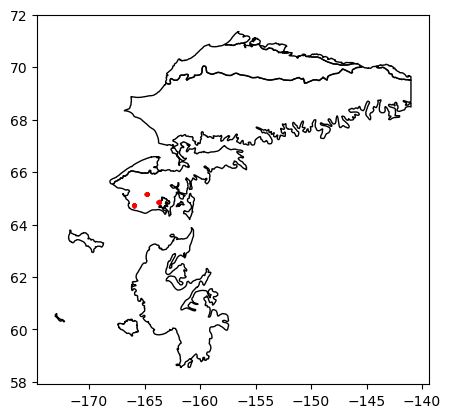

In [48]:
# plot the post-2010 alaskan tundra points
ax = ak_tundra.plot(edgecolor='black', facecolor='none')
fcover_and_aux.plot(ax=ax, color='red', markersize=3)

In [49]:
# remove geometry
fcover_and_aux['geometry'] = fcover_and_aux['geometry'].apply(lambda g: g.wkt if g is not None else None)

/tmp/ipykernel_2362349/2164478736.py:2: UserWarning: Geometry column does not contain geometry.
  fcover_and_aux['geometry'] = fcover_and_aux['geometry'].apply(lambda g: g.wkt if g is not None else None)


In [50]:
faa_li = len(fcover_and_aux.index)
faa_ui = len(fcover_and_aux.index.unique())
print(f'Number of plot visits in fcover_and_aux: {faa_li}')
print(f'Number of unique plot visits in fcover_and_aux: {faa_ui}')

Number of plot visits in fcover_and_aux: 97
Number of unique plot visits in fcover_and_aux: 97


In [51]:
# export species fcover
species_fcover_out = species_fcover.copy()
species_fcover_out = species_fcover_out[species_fcover_out['plotVisit'].isin(valid_uids)]
species_fcover_out = spf.replace_column_with_uid(species_fcover_out, uid_table, id_col='plotVisit', uid_col='UID', set_index=False, schema_key='species_fcover')
species_fcover_out = spf.format_column_dtypes(species_fcover_out, schema_key='species_fcover')
spf.export_dataframe(species_fcover_out, f'output_data/{source}_nonstandard_species_fcover.csv', schema_key='species_fcover', index=False)

In [52]:
# export pft fcover
covercols = [col for col in fcover_and_aux.columns if 'Cover' in col]
pft_fcover_out = fcover_and_aux[covercols]
pft_fcover_out = spf.replace_column_with_uid(pft_fcover_out.reset_index(), uid_table, id_col='plotVisit', uid_col='UID', set_index=True, schema_key='pft_fcover')
pft_fcover_out = spf.format_column_dtypes(pft_fcover_out, schema_key='pft_fcover')
spf.export_dataframe(pft_fcover_out, f'output_data/{source}_standard_pft_fcover.csv', schema_key='pft_fcover', index=True)

In [53]:
# export pft aux
auxcols = [col for col in fcover_and_aux.columns if 'Cover' not in col]
pft_aux = fcover_and_aux[auxcols]
pft_aux = spf.replace_column_with_uid(pft_aux.reset_index(), uid_table, id_col='plotVisit', uid_col='UID', set_index=True, schema_key='pft_aux')
pft_aux = spf.format_column_dtypes(pft_aux, schema_key='pft_aux')
spf.export_dataframe(pft_aux, f'output_data/{source}_plot_info.csv', schema_key='pft_aux', index=True)